<a href="https://colab.research.google.com/github/kcortinas/stackoverflow_2020_survey_gender_analysis/blob/main/Survey_2020_Women_in_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Overflow Developer Survey 2020 - Women in Data Science

## **1) Data Collection**

In [1]:
# Import libraries and connect with drive to load the data
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from google.colab import files
import io
import itertools
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
# Load datasets
path_survey = "/content/drive/My Drive/data/survey_results_public.csv"
path_schema = "/content/drive/My Drive/data/survey_results_schema.csv"
df_survey = pd.read_csv(path_survey)
df_schema = pd.read_csv(path_schema)

##**2) Data Cleaning**

In [84]:
# Data cleaning and plotting functions to be used when answering analysis questions

def get_list_possible_values(input_df, column_name):
    '''
    Returns the list of unique values in the column

    INPUT - df - pandas dataframe
            column_name - string - the name of the column you would like to analyse
    OUTPUT - 
            set - set of unique values in the given column
    '''

    # Make sure the column contains a list of values
    input_df[column_name] = input_df[column_name].apply(lambda s: str(s).split(';'))
    
    return set(itertools.chain.from_iterable(input_df[column_name]))

def transform_column_list_values(input_df, column_name):
    '''
    Changes type of a given column: from string to list of values

    INPUT - df - pandas dataframe
            column_name - string - the name of the column you would like to transform
    OUTPUT - 
            df - pandas dataframe with the transformed column
    '''

    # Transform column
    input_df[column_name] = input_df[column_name].apply(lambda s: str(s).split(';'))
    
    return input_df

def get_count_value_in_list_column(input_series):
    '''
    Adds an indicator to the dataframe to indicate the type of job

    INPUT - df - pandas dataframe
            job_column - string - the name of the column containing job information
            job_cue - string - an indicator of the profession, e.g. 'data'
    OUTPUT - 
            df - pandas dataframe with an added indicator for a given type of job
    '''
    
    return pd.Series([item for sublist in input_series for item in sublist]).value_counts()

def analyse_ratio_men_women_multiple_value_field(input_df, column_name, type_plot, title_plot):
    '''
    Analyses the ratio of men over women for different values in a multi-value field

    INPUT - input_df - pandas dataframe
            column_name - string - the name of the column containing multi-value info
            type_plot - int - the type of plot to be returned (0: barplot, 1: scatterplot)
            title_plot - string - title for the plot
    OUTPUT - 
            A plot showing how the ratio of men/women varies for multiple values in the input column
    '''

    # Create dataframes by gender group to compute counts independently
    input_df_men_women = input_df[(input_df.Gender == 'Man') | (input_df.Gender == 'Woman')]
    input_df_men = input_df[input_df.Gender == 'Man']
    input_df_women = input_df[input_df.Gender == 'Woman']

    # Count the amount of individuals in each group informing a given value in the multi-field column
    total_values_series = get_count_value_in_list_column(input_df_men_women[column_name])
    men_values_series = get_count_value_in_list_column(input_df_men[column_name])
    women_values_series = get_count_value_in_list_column(input_df_women[column_name])

    # Aggregate counts for each group in a dataframe and compute ratio of men over women
    df_gender = pd.DataFrame({'total_respondents': total_values_series, 'men': men_values_series, 'women': women_values_series})
    df_gender['ratio_men_women'] = df_gender['men']/df_gender['women']
    baseline_ratio_men_women = input_df_men.shape[0] / input_df_women.shape[0]

    if type_plot == 0:
      fig, axs = plt.subplots(1,1, figsize = (16, 16))
      
      # Sort data before plotting
      df_gender_sorted = df_gender.sort_values('ratio_men_women',ascending=False)
      
      # Create palette based on total amount of respondents for each value in the input column
      pal = sns.color_palette("Greens_d", len(df_gender_sorted.total_respondents))
      rank = (df_gender_sorted.total_respondents.rank(ascending = False).astype(int) - 1) # rank values
      
      barplot_gender = sns.barplot(
          data = df_gender_sorted,
          y = df_gender_sorted.index,
          x = df_gender_sorted.ratio_men_women,
          palette=np.array(pal[::-1])[rank]
          )
      plt.axvline(baseline_ratio_men_women, color='r', linestyle = 'dashed')
      barplot_gender.set_title(title_plot, fontsize = 18)
      plt.show()

    elif type_plot == 1:
      fig, axs = plt.subplots(1,1, figsize = (16, 16))
      # Filter to get a cleaner scatter plot
      df_gender_filtered = df_gender[df_gender.total_respondents>500]
      scatter_plot_gender = sns.scatterplot(
        data = df_gender_filtered,
        x = 'total_respondents',
        y = 'ratio_men_women',
        color = 'r'
      )
      plt.axhline(baseline_ratio_men_women, color='r', linestyle = 'dashed')
      for i in range(df_gender_filtered.shape[0]):
        plt.text(x=df_gender_filtered.total_respondents[i]+0.8,y=df_gender_filtered.ratio_men_women[i]+0.2,s=df_gender_filtered.index[i])
      scatter_plot_gender.set_title(title_plot, fontsize = 18)
      plt.show()

    else:
      print("Please indicate the type of plot to be returned: 0 - Barplot, 1 - Scatterplot")
  
def discretise_numeric_variables(df, column_to_discretise, boundaries):
    '''
    Discretises numeric variables into a given amount of buckets

    INPUT - input_df - pandas dataframe
            column_to_discretise - string - the name of the column to discretise
            boundaries - list - a list of boundaries to define the buckets
    OUTPUT - 
            df - pandas dataframe containing the new categorical variable
    '''
    col_name = str(column_to_discretise) + '_cat'
    boundaries = sorted({df[column_to_discretise].min(), df[column_to_discretise].max() + 1} | set(boundaries))
    df[col_name] = pd.cut(df[column_to_discretise], bins=boundaries, right=False)
    df[col_name]= str(column_to_discretise) + df[col_name].astype(str)
    return df

def analyse_gender_by_category(input_df, category_column, gender_column, order_list, title):
    '''
    Discretises numeric variables into a given amount of buckets

    INPUT - input_df - pandas dataframe
            category_column - string - the name of the categorical column to analyse gender differences
            gender_column - string - the name of the gender column
            order_list - list - a list of string values to indicate ordering in the plot
            title - string - specific title for the barplot
    OUTPUT - 
            A barplot showing differences in proportions for different category values and gender groups
    '''
    
    df_gender = pd.DataFrame({'Proportion': input_df.groupby(gender_column)[category_column].value_counts() * 100 / input_df.groupby(gender_column)['Respondent'].count()})
    df_gender.reset_index(inplace=True)
    
    fig, axs = plt.subplots(1,1, figsize = (16, 16))
    
    plot_gender = sns.barplot(
        data = df_gender,
        y = category_column,
        x = 'Proportion',
        hue = gender_column,
        palette= 'Set2',
        order = order_list)
    
    plot_gender.set_title(title, fontsize = 18)
    plt.show()

def analyse_risk_ratio_by_category(input_df, category_column, gender_column, title):
  '''
    Analyses how many times the ratio of men over women increases/decreases as compared to baseline for different category values

    INPUT - input_df - pandas dataframe
            category_column - string - the name of the categorical column to analyse gender differences
            gender_column - string - the name of the gender column
            title - string - specific title for the barplot
    OUTPUT - 
            A barplot showing differences in risk ratios for different category values and gender groups
    '''
  
  df_men_women = input_df
  df_men = input_df[input_df[gender_column] == 'Man']
  df_women = input_df[input_df[gender_column] == 'Woman']
  baseline_ratio_men_women = df_men.shape[0] / df_women.shape[0]
  df_gender = pd.DataFrame({'risk_ratio_men_women': (df_men.groupby(category_column)['Respondent'].count() / df_women.groupby(category_column)['Respondent'].count()).fillna(0)/baseline_ratio_men_women})
  df_gender.reset_index(inplace = True)
  
  fig, axs = plt.subplots(1,1, figsize = (16, 16))
  # Sort data before plotting
  df_gender_sorted = df_gender[df_gender.risk_ratio_men_women > 0].sort_values('risk_ratio_men_women',ascending=False)
  
  plot_risk_ratio_gender = sns.barplot(
    data = df_gender_sorted,
    y = df_gender_sorted[category_column],
    x = df_gender_sorted.risk_ratio_men_women,
    palette="Greens_d")
  
  plt.axvline(1.0, color='r', linestyle = 'dashed')
  
  plot_risk_ratio_gender.set_title(title, fontsize = 18)
  plt.show()

def analyse_gender_different_categories(input_df, category_column, gender_columns):
  '''
    Analyses gender differences considering two different categorical columns

    INPUT - input_df - pandas dataframe
            category_column - string - the name of the categorical column to analyse gender differences
            gender_column - list of strings - the name of the gender column and the additional categorical column to group by
            title - string - specific title for the barplot
    OUTPUT - 
            A barplot showing differences in proportions by gender and categorical values
    '''

    # Ensure only respondents who answered the questions are considered
  df_analysis_different_categories = input_df.dropna(subset=[category_column], axis = 0)
  
  df_gender = pd.DataFrame({'proportion_overtime': df_analysis_different_categories.groupby(gender_columns)[category_column].value_counts() * 100 
                            / df_analysis_different_categories.groupby(gender_columns)['Respondent'].count()})
  df_gender.reset_index(inplace=True)
  
  sns.catplot(
    data = df_gender,
    y = category_column,
    x = 'proportion_overtime',
    hue = gender_columns[0],
    col = gender_columns[1],
    kind = 'bar',
    palette= 'Set2',
    height = 16
    )


##**3) Analysis**

**1.   Gender diversity in Data Science (DS) as compared to other tech fields: are there more women in DS?**

To assess gender diversity in Data Science as compared to other fields, we'll use the column *DevType*. Since women is a minority group in the survey, to quantify differences between industries we'll use as a metric the ratio of men over women.

Before comparing the ratio on different job types, let's see what the column *DevType* looks like:

In [85]:
get_list_possible_values(df_survey, 'DevType')

{'Academic researcher',
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 'Database administrator',
 'Designer',
 'DevOps specialist',
 'Developer, QA or test',
 'Developer, back-end',
 'Developer, desktop or enterprise applications',
 'Developer, embedded applications or devices',
 'Developer, front-end',
 'Developer, full-stack',
 'Developer, game or graphics',
 'Developer, mobile',
 'Educator',
 'Engineer, data',
 'Engineer, site reliability',
 'Engineering manager',
 'Marketing or sales professional',
 'Product manager',
 'Scientist',
 'Senior executive/VP',
 'System administrator',
 'nan'}

Some respondents didn't inform their job type. Before deciding how to treat missings in the *DevType* column, let's determine what's the missing proportion first:

In [86]:
print(np.round(df_survey[df_survey.DevType.apply(lambda s: 'nan' in s)].shape[0] * 100 / df_survey.shape[0], 2), '%')

23.41 %


While we could impute missings or infer the job type using other predictors via a supervised model, in this case our goal is to understand whether the ratio of men over women is higher or lower in Data Science as compared to other industries. Since the missings correspond to respondents not open to share this information in the survey and we still have almost 80% of values informed, to answer the question of interest we'll only consider the respondents who informed their job type in the questionnaire and drop the missing rows:

In [87]:
df_survey = df_survey[df_survey.DevType.apply(lambda s: 'nan' not in s)]

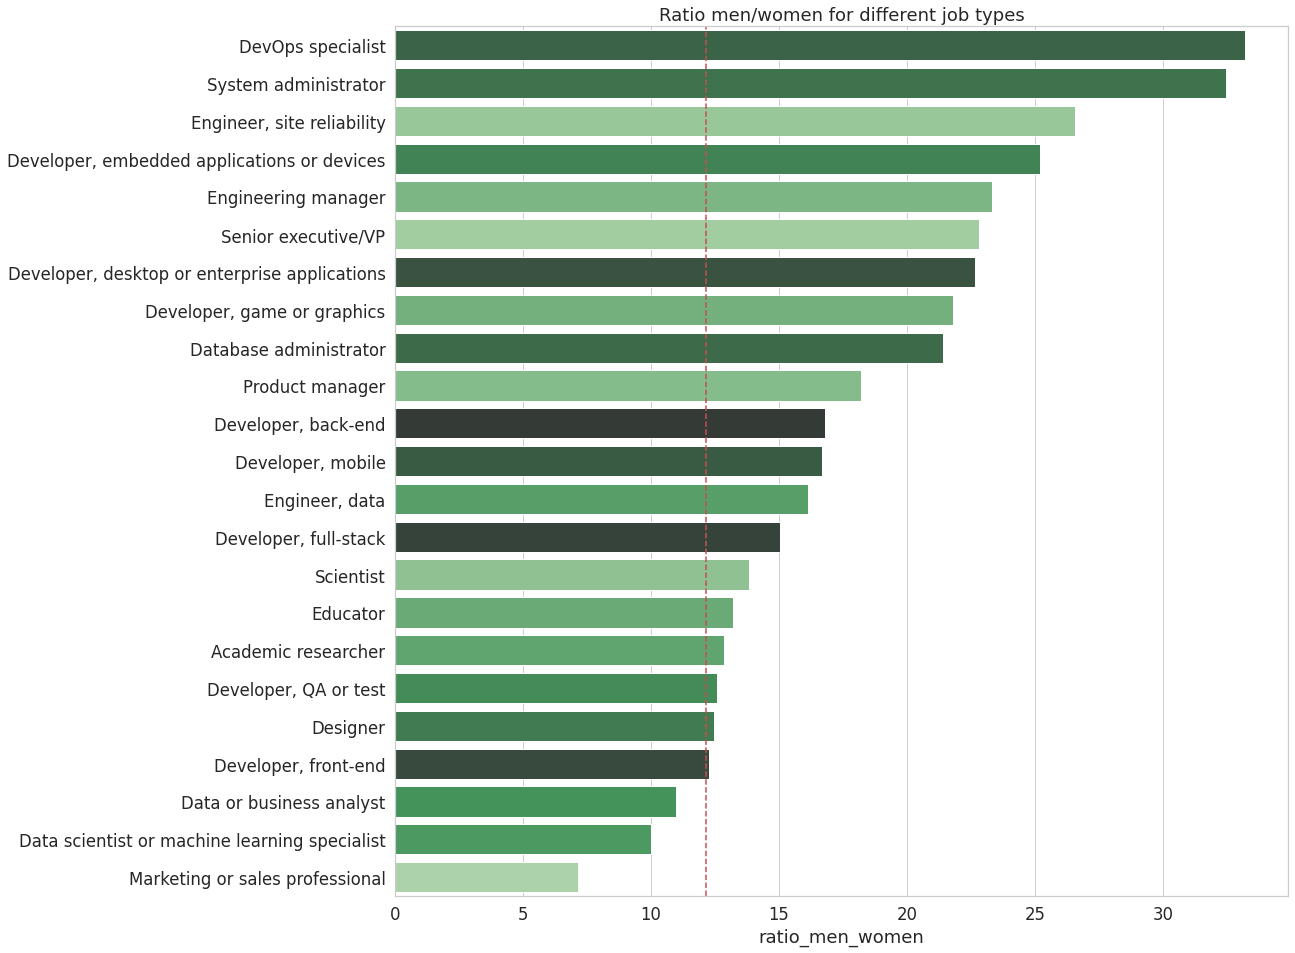

In [89]:
analyse_ratio_men_women_multiple_value_field(df_survey, 'DevType', 0, 'Ratio men/women for different job types')

Most respondents in the survey are back-end, full-stack or front-end developers (in the graph above the darker the colour, the more respondents). As expected, in any job category there are more men than women: for any woman taking the survey there are on average a minimum of 5 men. Except from data engineering, the ratio of men over women in data job types (data/business analyst, data scientist or ML specialist) is below the average: data professionals are about 10 times more likely to be men than women, while for DevOps specialist or System administrators the ratio is greater than 30.

Data or business analyst, data scientist or machine learning specialist and marketing or sales professionals are the job types where women have greater representation.

**2.   In Data Science, do women tend to have comparable/more/less coding experience than men?**

To answer this question, we'll use the column *YearsCode* corresponding to the answer of the question "*Including any education, how many years have you been coding in total?*" Since we only want to focus on data professionals and specific differences between men and women, we filter out other job types or gender values:

In [118]:
df_survey_data = df_survey[(df_survey.DevType.apply(lambda s: ('Data scientist or machine learning specialist' or 'Data or business analyst') in [item for item in s])) & ((df_survey.Gender == 'Man')|(df_survey.Gender == 'Woman'))]

*YearsCode* is a categorical value. Since it has many levels, we'll define our own buckets:

In [91]:
df_survey_data.YearsCode.value_counts()

10                    296
6                     223
8                     212
5                     211
7                     207
15                    180
4                     168
20                    161
12                    144
9                     135
3                     119
11                    109
13                     94
30                     86
14                     83
16                     78
18                     77
17                     76
25                     70
2                      49
35                     48
22                     44
21                     39
40                     35
23                     33
19                     32
24                     28
28                     26
26                     26
1                      24
Less than 1 year       24
27                     23
38                     21
32                     20
34                     17
33                     16
37                     12
29                     11
36          

In [92]:
print('Proportion of missing values in column YearsCode: ', np.round(np.sum(df_survey_data.YearsCode.isnull()) * 100 / df_survey_data.shape[0], 2), '%')

Proportion of missing values in column YearsCode:  0.77 %


We have 0.77% of missing values in the column *YearsCode*, since the amount of missings is very low, we drop these observations:

In [93]:
df_survey_data_years_code = df_survey_data.dropna(subset=['YearsCode'], axis=0)

In [94]:
# Replace string values with numbers before transforming to numeric
is_less_1_year = (df_survey_data_years_code.YearsCode == 'Less than 1 year')
df_survey_data_years_code.loc[is_less_1_year, 'YearsCode'] = 0
is_more_50_years = (df_survey_data_years_code.YearsCode == 'More than 50 years')
df_survey_data_years_code.loc[is_more_50_years, 'YearsCode'] = 50
# Transform variable to numeric before discretising
df_survey_data_years_code.YearsCode = df_survey_data_years_code.YearsCode.astype(float)
# Discreatise variable with new buckets
df_survey_data_years_code = discretise_numeric_variables(df_survey_data_years_code, 'YearsCode', boundaries = [5, 10, 15, 20, 30, 50])
# Replace values for categories
df_survey_data_years_code.YearsCode_cat.replace({'YearsCode[0.0, 5.0)': 'Less than 5 years', 
                                                'YearsCode[5.0, 10.0)': 'Between 5 and 10 years',
                                                'YearsCode[10.0, 15.0)': 'Between 10 and 15 years', 
                                                'YearsCode[15.0, 20.0)': 'Between 15 and 20 years',
                                                'YearsCode[20.0, 30.0)': 'Between 20 and 30 years', 
                                                'YearsCode[30.0, 50.0)': 'More than 30 years',
                                                'YearsCode[50.0, 51.0)': 'More than 30 years'},
                                     inplace = True)
# Validate new field
df_survey_data_years_code.YearsCode_cat.value_counts()

Between 5 and 10 years     988
Between 10 and 15 years    726
Between 20 and 30 years    461
Between 15 and 20 years    443
Less than 5 years          384
More than 30 years         335
Name: YearsCode_cat, dtype: int64

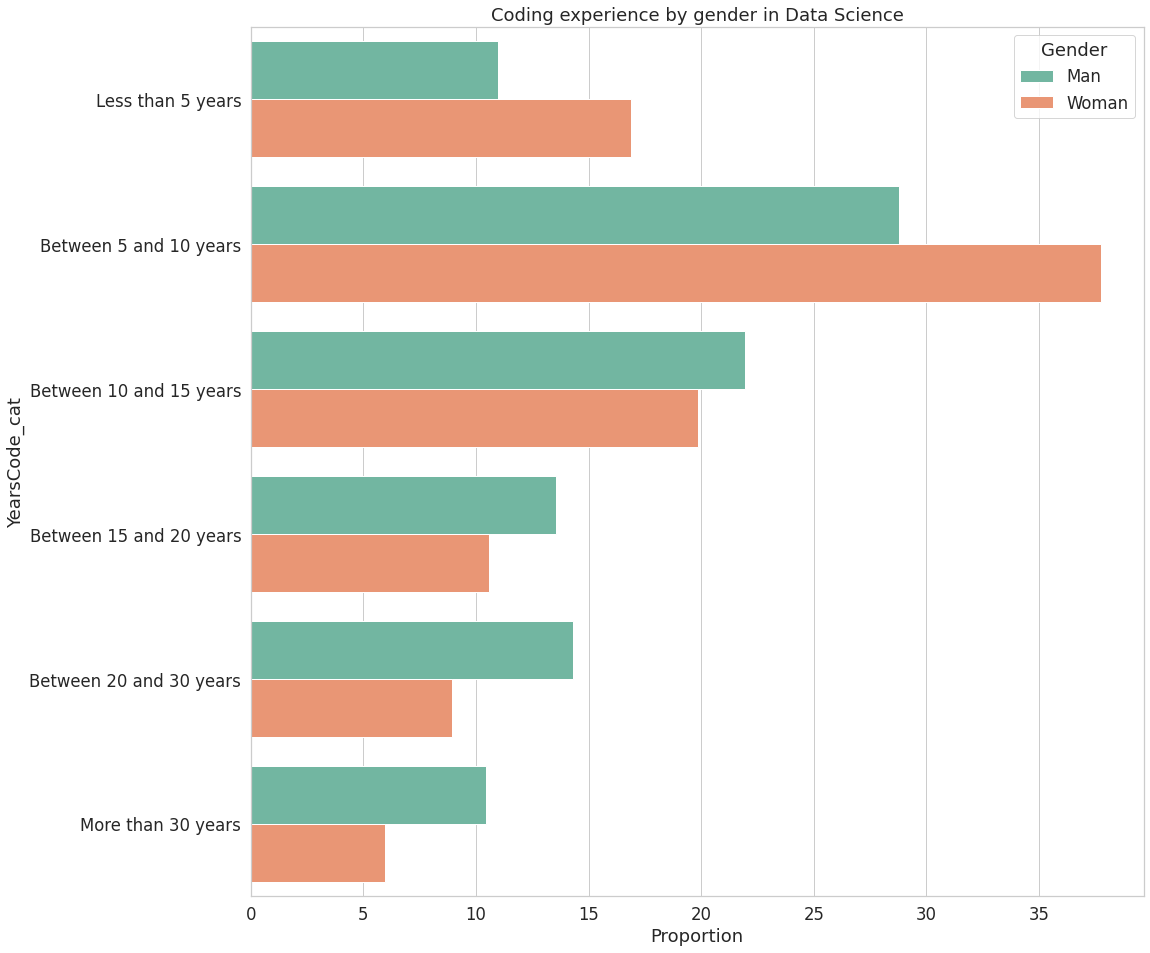

In [95]:
# Plot differences in years of coding experience by gender
order_list_plot = ['Less than 5 years', 'Between 5 and 10 years', 'Between 10 and 15 years', 'Between 15 and 20 years', 'Between 20 and 30 years', 'More than 30 years']
title_plot = 'Coding experience by gender in Data Science'
analyse_gender_by_category(df_survey_data_years_code, 'YearsCode_cat', 'Gender', order_list_plot, title_plot)

The proportion of women indicating less coding experience in the survey (less than 5 years and between 5 and 10 years) is greater than the corresponding proportion of men. When experience is greater than 10 years the opposite is true: bigger proportions of men report more than 10 years of experience and the gap gets bigger when experience goes above 20 years. This is an indication that in general, data professionals women who took the survey are less experienced in coding and newer to the field than men.

**3.   Gender diversity in Data Science (DS) by country: where it's easier/harder to get into the field?**

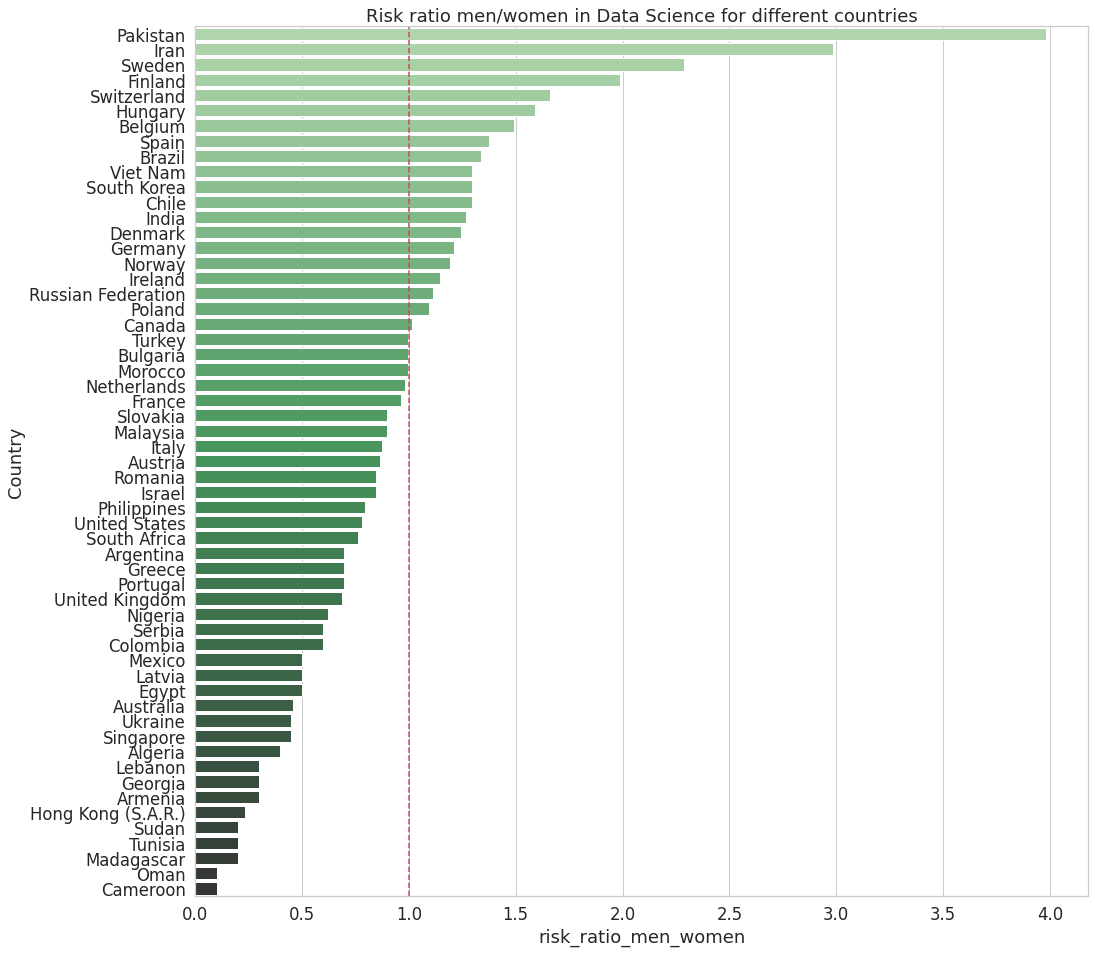

In [96]:
title_plot = 'Risk ratio men/women in Data Science for different countries'
analyse_risk_ratio_by_category(df_survey_data, 'Country', 'Gender', title_plot)

In Pakistan, the proportion of men over women is around 4 times bigger than the average in the survey, followed by Iran, Sweden and Finland. The ratio in the US, where most respondents are from, is below the baseline (dashed red line in the plot above).

**4.   Are women in Data Science 'over educated'?**

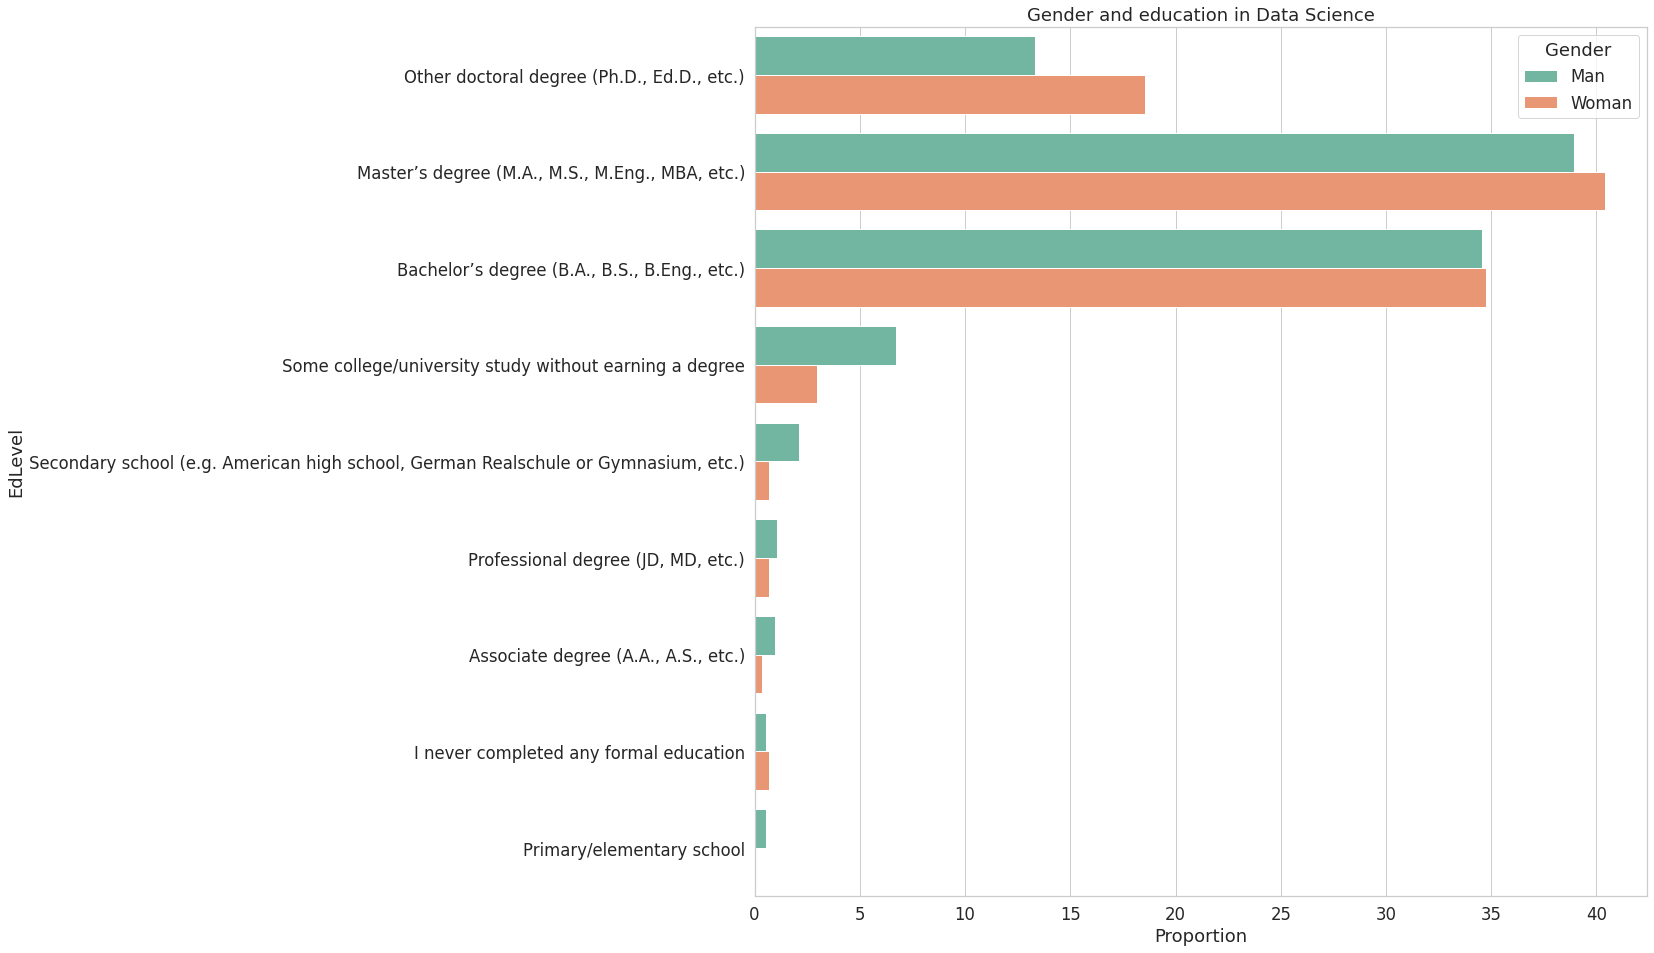

In [98]:
title_plot = 'Gender and education in Data Science'
order_list = ['Other doctoral degree (Ph.D., Ed.D., etc.)', 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)', 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)', 'Some college/university study without earning a degree', 
              'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)', 'Professional degree (JD, MD, etc.)', 'Associate degree (A.A., A.S., etc.)', 'I never completed any formal education',
              'Primary/elementary school']
analyse_gender_by_category(df_survey_data, 'EdLevel', 'Gender', order_list, title_plot)

The proportion of women who participated in the survey having PhDs and Masters is higher than men's. For standard education in Data Science, Bachelor's Degree, there aren't key differences in proportions by gender. When looking at respondents with no formal education or university degrees, men tends to have greater proportions than women.

**5.   Are women underpaid in Data Science? Do women tend to work overtime?**

To compare the distributions of salaries between women and men we focus on the top 5 countries in the data set and analyse distributions by country, since compensations can be different in different locations. We also take a look at the overall density functions:

In [99]:
# United States, United Kingdom, India, Germany and Canada are where most respondents are from
df_survey_data.Country.value_counts()

United States                734
India                        371
Germany                      237
United Kingdom               198
Canada                       112
                            ... 
Azerbaijan                     1
Nomadic                        1
Congo, Republic of the...      1
Bosnia and Herzegovina         1
Kosovo                         1
Name: Country, Length: 124, dtype: int64

In [100]:
# Consider only the answers from the top 5 countries and where respondents inform their salary
df_survey_data_salary_top_5_countries = df_survey_data[((df_survey_data.Country == 'United Kingdom')|
                                                        (df_survey_data.Country == 'United States')|
                                                        (df_survey_data.Country == 'India')|
                                                        (df_survey_data.Country == 'Germany')|
                                                        (df_survey_data.Country == 'Canada')) & 
                                                       ((df_survey_data.Gender == 'Man')|(df_survey_data.Gender == 'Woman'))].dropna(subset=['CompTotal'], axis = 0)

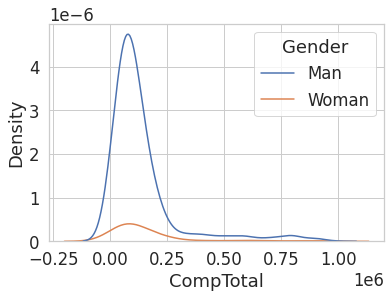

In [101]:
# Get rid of outliers & plot overall density function to spot differences by gender
df_survey_data_salary_top_5_countries = df_survey_data_salary_top_5_countries[df_survey_data_salary_top_5_countries.CompTotal<1e6]
sns.kdeplot(data=df_survey_data_salary_top_5_countries, x="CompTotal", hue="Gender")

Both distributions are right-skewed and centered around the same values: no clear differences between genders.

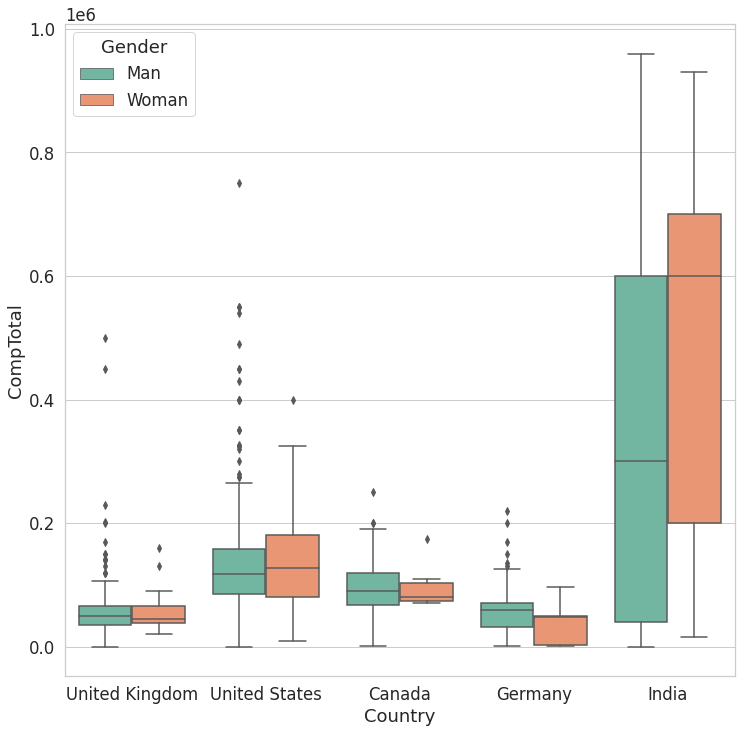

In [102]:
# Compare overall medians and quartiles for different countries
sns.set(font_scale=1.5, style='whitegrid')
fig_dims = (12, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x="Country", y="CompTotal", data=df_survey_data_salary_top_5_countries, hue = 'Gender', palette = 'Set2')

Overall, salaries distributions tend to be similar between genders. While in India, the median salary for women participating in the survey is much higher than men's, in the rest of the countries there aren't clear patterns suggesting women are underpaid.

What about overtime?

In [103]:
df_survey_data.NEWOvertime.value_counts()

Often: 1-2 days per week or more                            940
Sometimes: 1-2 days per month but less than weekly          794
Occasionally: 1-2 days per quarter but less than monthly    553
Rarely: 1-2 days per year or less                           369
Never                                                       264
Name: NEWOvertime, dtype: int64

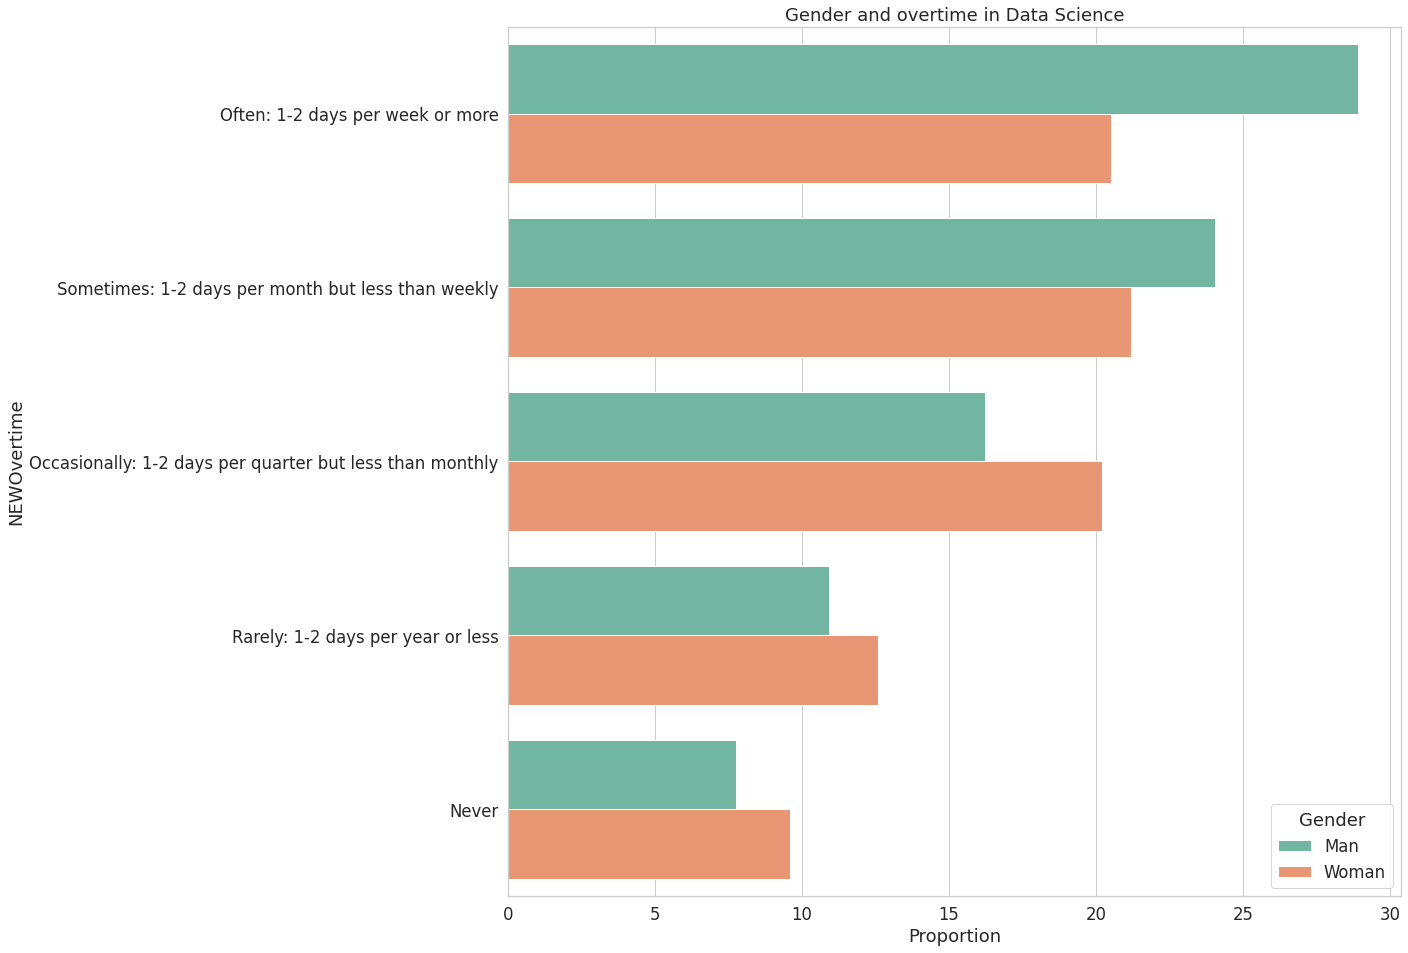

In [104]:
title_plot = 'Gender and overtime in Data Science'
order_list = ['Often: 1-2 days per week or more', 'Sometimes: 1-2 days per month but less than weekly', 
              'Occasionally: 1-2 days per quarter but less than monthly', 'Rarely: 1-2 days per year or less', 
              'Never']
analyse_gender_by_category(df_survey_data, 'NEWOvertime', 'Gender', order_list, title_plot)

In the survey, more men than women reported working overtime on a weekly and monthly basis. Data Science women professionals taking the survey reported on higher numbers than men occasionally/rarely/never working outside working hours. Looking at these numbers, we can infer than men tend to work more overtime than women in the field. Does this change when looking at different age buckets?

In [105]:
# Filter data to consider only respondants aged > 18 years old
df_survey_data_age = df_survey_data[df_survey_data.Age >= 18]
# Discretise age and rename different age buckets
df_survey_data_age = discretise_numeric_variables(df_survey_data_age, 'Age', boundaries = [25, 30, 35, 45])
df_survey_data_age.Age_cat.replace({'Age[18.0, 25.0)': 'Between 18 and 25 years old', 
                                                'Age[25.0, 30.0)': 'Between 25 and 30 years old',
                                                'Age[30.0, 35.0)': 'Between 30 and 35 years old', 
                                                'Age[35.0, 45.0)': 'Between 35 and 45 years old',
                                                'Age[45.0, 86.0)': 'More than 45 years old'},
                                     inplace = True)
df_survey_data_age.Age_cat = df_survey_data_age.Age_cat.astype('category')
# Check values for the new field
df_survey_data_age.Age_cat.value_counts()

Between 25 and 30 years old    877
Between 30 and 35 years old    635
Between 35 and 45 years old    615
Between 18 and 25 years old    552
More than 45 years old         268
Name: Age_cat, dtype: int64

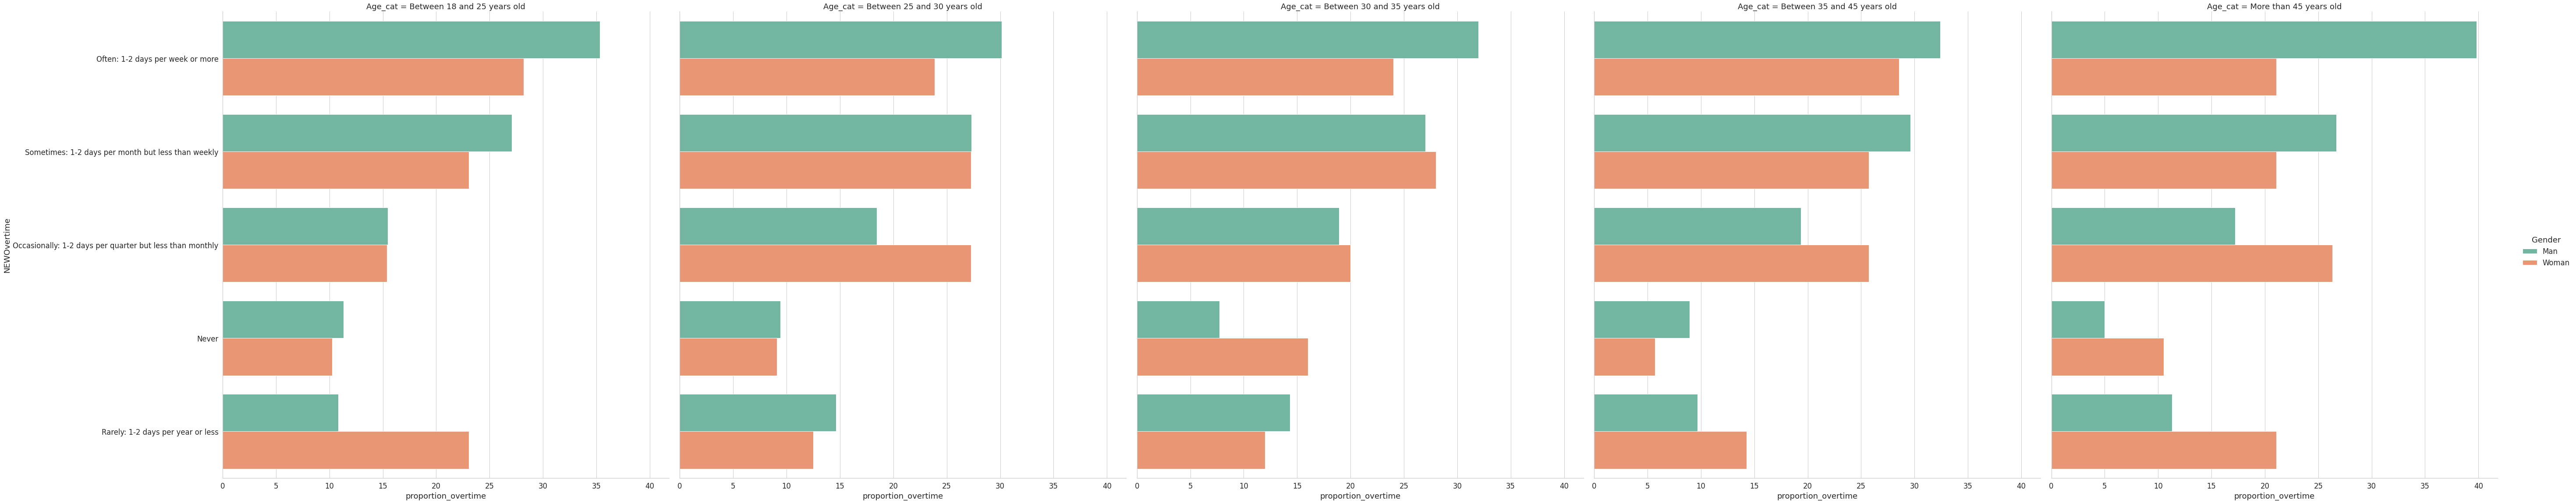

In [106]:
# Plot differences in overtime by gender and age
analyse_gender_different_categories(df_survey_data_age, 'NEWOvertime', ['Gender', 'Age_cat'])

Although for all age buckets more men than women in the survey report working often outside working hours, the gap gets smaller for women aged between 35 and 45 years old (possibly due to maternity?). When looking at ages between 25 and 35 years old, there are similar proportions of men and women reporting working overtime on a monthly basis. When looking at respondents older than 45 years old, bigger proportions of men over women tend to usually work overtime, with women reporting more frequently never working overtime or rarely.

**7.   Do women in Data Science code as a hobby? What do they code? Do they prefer R over Python?**

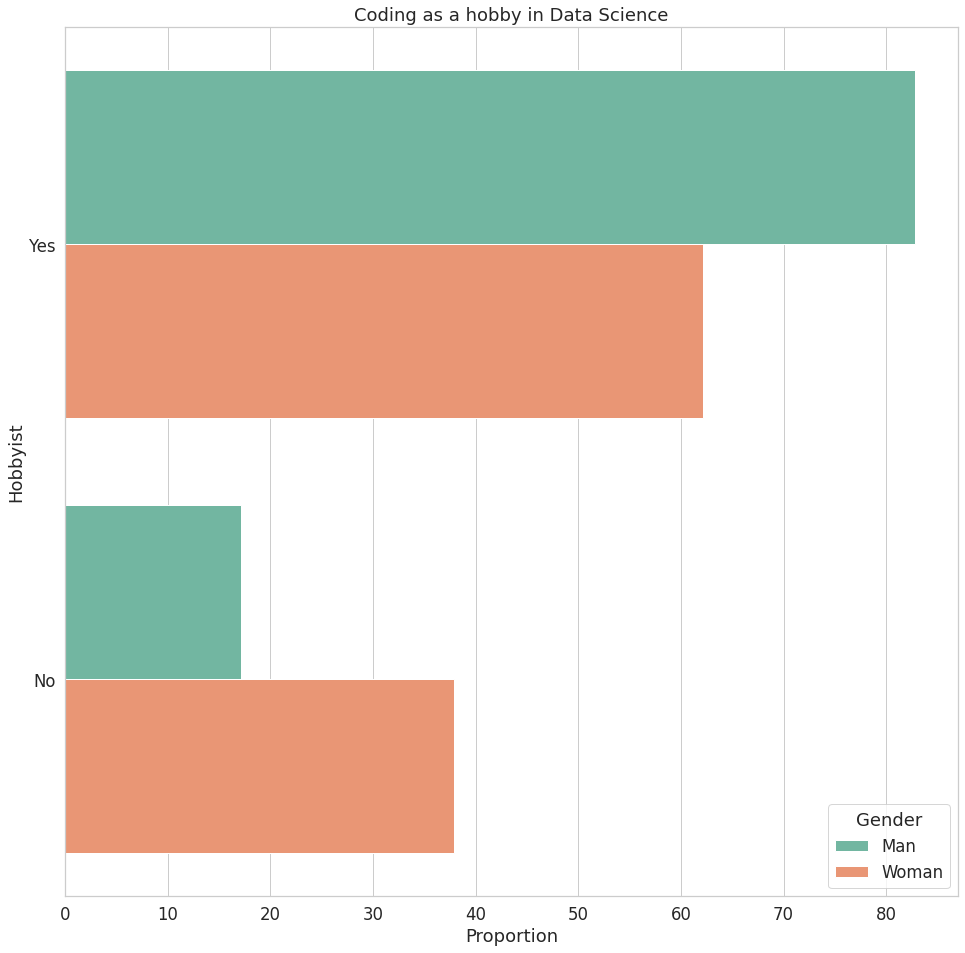

In [107]:
title_plot = 'Coding as a hobby in Data Science'
order_list = ['Yes', 'No']
analyse_gender_by_category(df_survey_data, 'Hobbyist', 'Gender', order_list, title_plot)

In general, most respondents working in Data Science code as a hobby. However, when looking at gender, there's a bigger proportion of men reporting coding as a hobby, and a bigger proportion of women not coding in their free time.

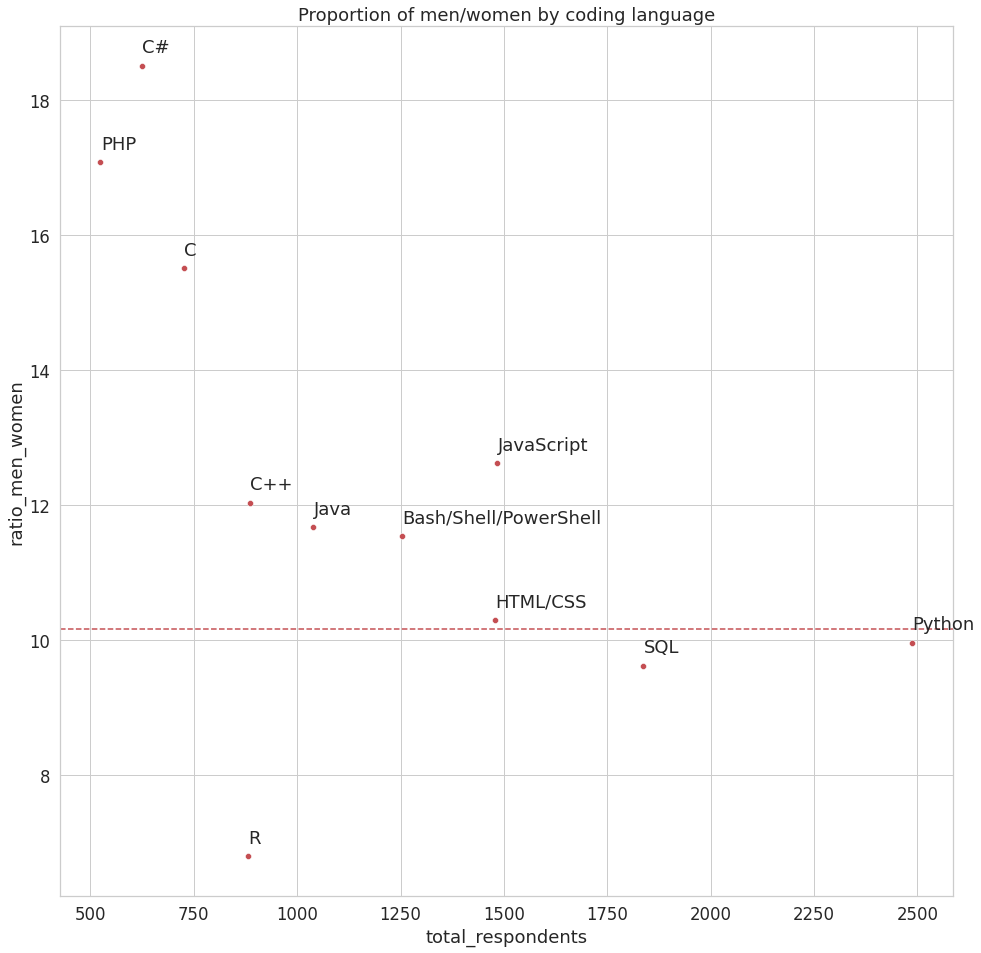

In [108]:
# Ensure Language column is iterable first (list of values)
df_survey_data = transform_column_list_values(df_survey_data, 'LanguageWorkedWith')
# Plot
title_plot = 'Proportion of men/women by coding language'
analyse_ratio_men_women_multiple_value_field(df_survey_data, 'LanguageWorkedWith', 1, title_plot)

On average, there's a bigger proportion of women coding R as compared to the baseline and as compared to coding Python.

**8.   Are women in Data Science actively looking for a job? What are the reasons of hunt? Do women have different reasons than men?**

In [109]:
df_survey_data.JobSeek.value_counts()

I’m not actively looking, but I am open to new opportunities    1630
I am not interested in new job opportunities                     689
I am actively looking for a job                                  545
Name: JobSeek, dtype: int64

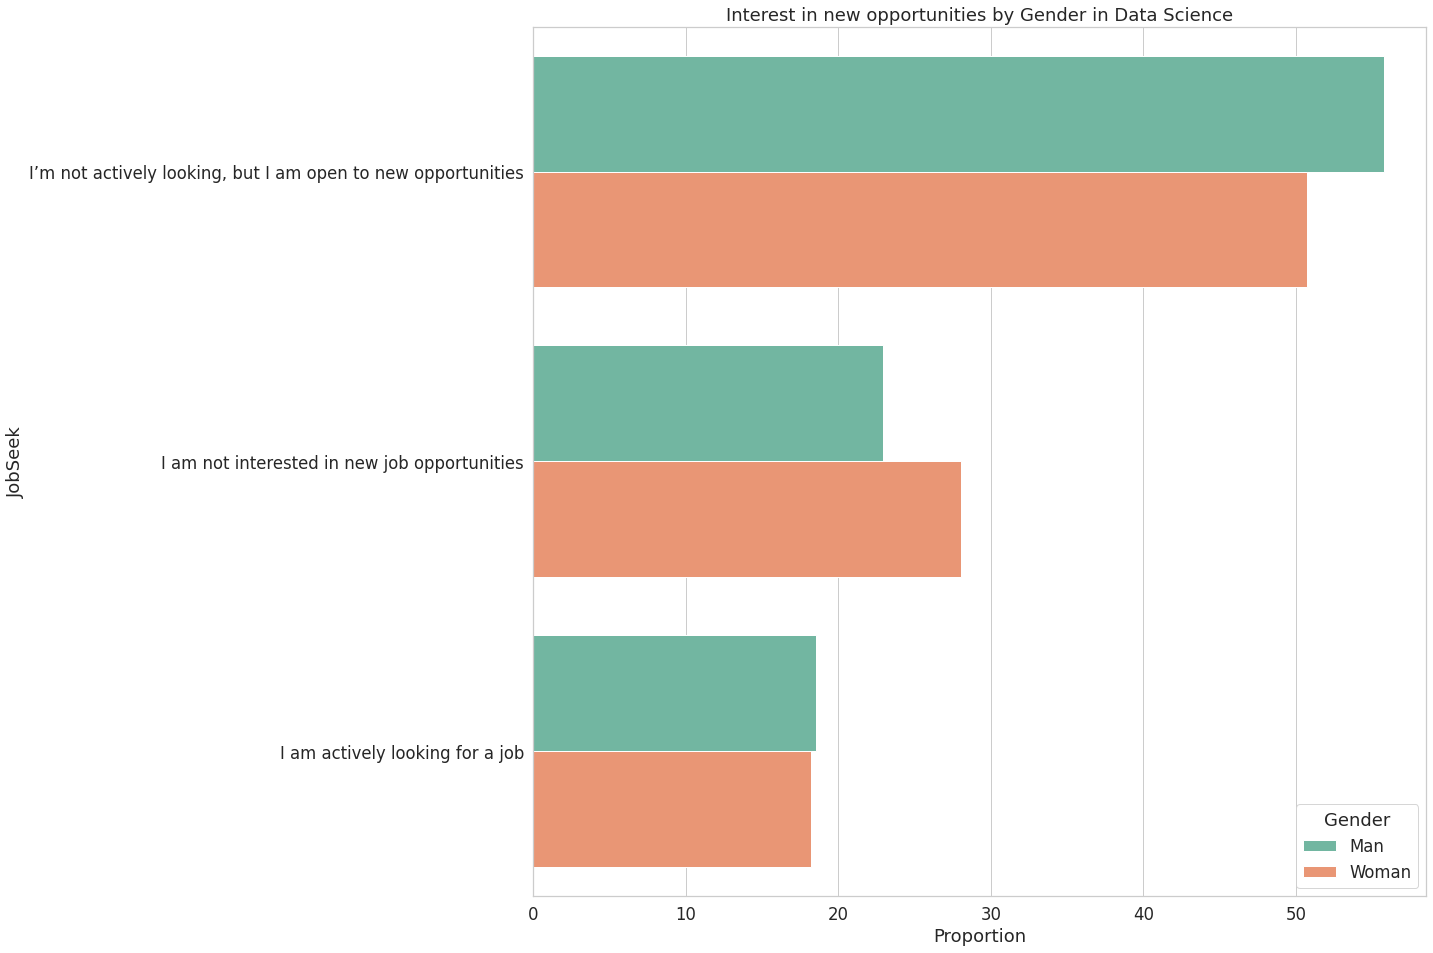

In [110]:
title_plot = 'Interest in new opportunities by Gender in Data Science'
order_list = ['I’m not actively looking, but I am open to new opportunities', 
              'I am not interested in new job opportunities',
              'I am actively looking for a job']
analyse_gender_by_category(df_survey_data, 'JobSeek', 'Gender', order_list, title_plot)

In general, the's a bigger proportion of men not actively looking for new opportunities but open to listen and a bigger proportion of women not interested in new job opportunities.

In [ ]:
# Ensure NEWJobHunt column is iterable first (list of values)
df_survey_data = transform_column_list_values(df_survey_data, 'NEWJobHunt')

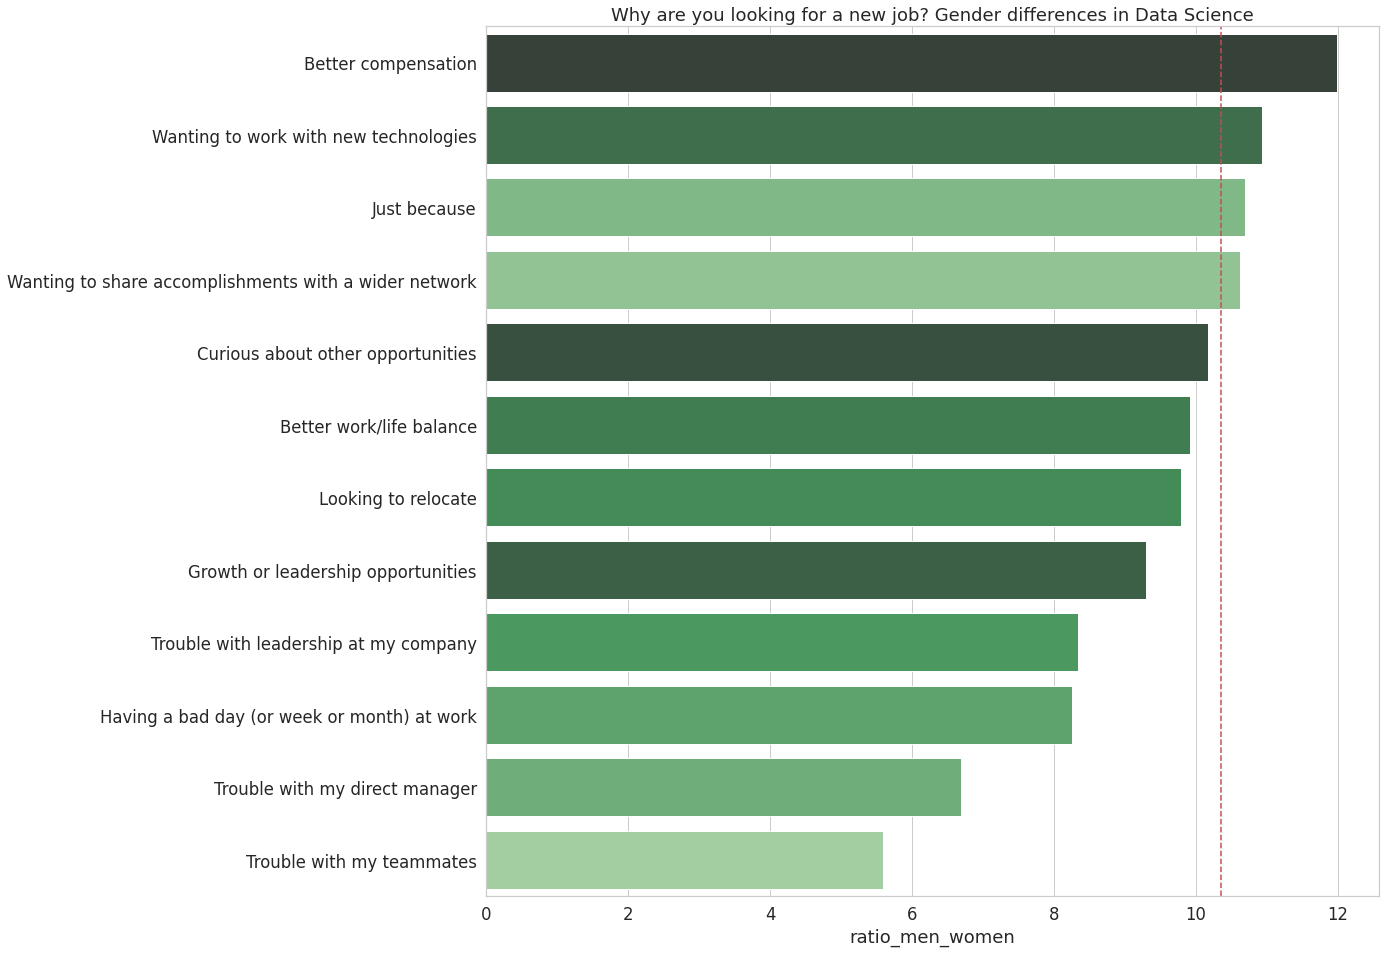

In [113]:
# Consider only respondents who replied to the question
df_survey_data_jobhunt = df_survey_data[df_survey_data.NEWJobHunt.apply(lambda s: 'nan' not in s)]
# Plot
title_plot = 'Why are you looking for a new job? Gender differences in Data Science'
analyse_ratio_men_women_multiple_value_field(df_survey_data_jobhunt, 'NEWJobHunt', 0, title_plot)

In general, respondents who're looking for better compensations and wanting to work with new technologies are more likely than average to be men, while respondents looking for new opportunities because they have trouble with teammates, direct manager or leadership are more likely than average to be women (average represented by the red dashed line in the graph above).

**9.   What are the most important factors when considering a job offer? Does this 'valuation' differ by gender?**

In [115]:
# Ensure JobFactors column is iterable first (list of values)
df_survey_data = transform_column_list_values(df_survey_data, 'JobFactors')

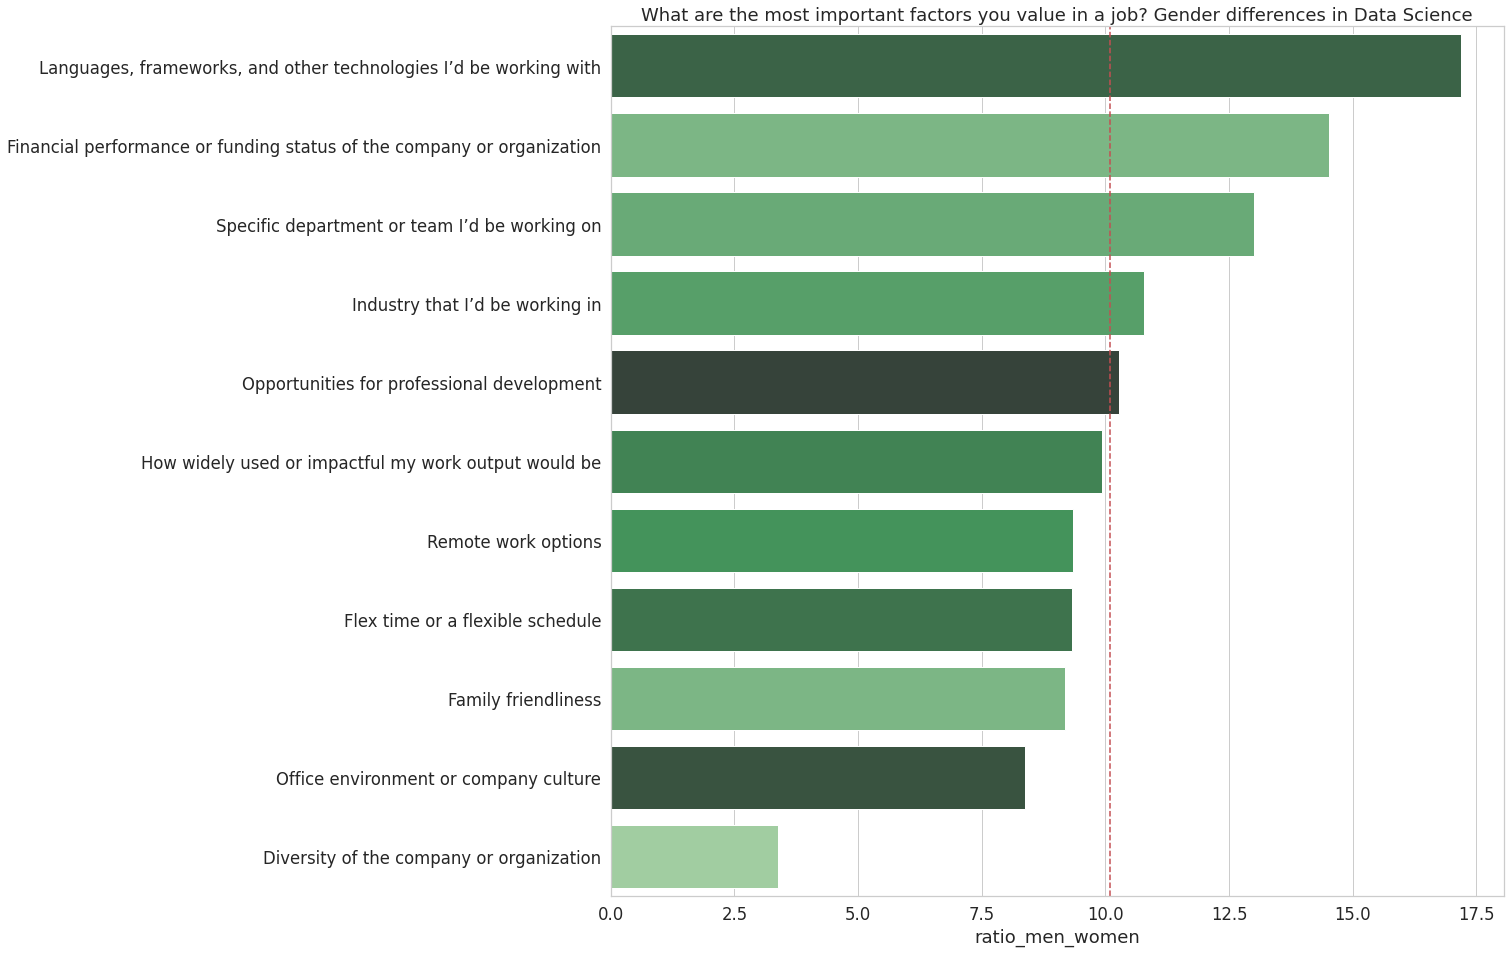

In [116]:
# Consider only respondents who replied to the question
df_survey_data_job_factors = df_survey_data[df_survey_data.JobFactors.apply(lambda s: 'nan' not in s)]
# Plot
title_plot = 'What are the most important factors you value in a job? Gender differences in Data Science'
analyse_ratio_men_women_multiple_value_field(df_survey_data_job_factors, 'JobFactors', 0, title_plot)

In general, respondents who value in a job offer the technologies they'd be working with, the financial performance of the company or the specific department/team they'd be working with are more likely than average to be men, while respondents valuing diversity within the organization, office environment and culture and family friendliness are more likely than average to be women (average represented by the red dashed line in the graph above).

**10.   Do women tend to work in smaller companies or large corporations?**

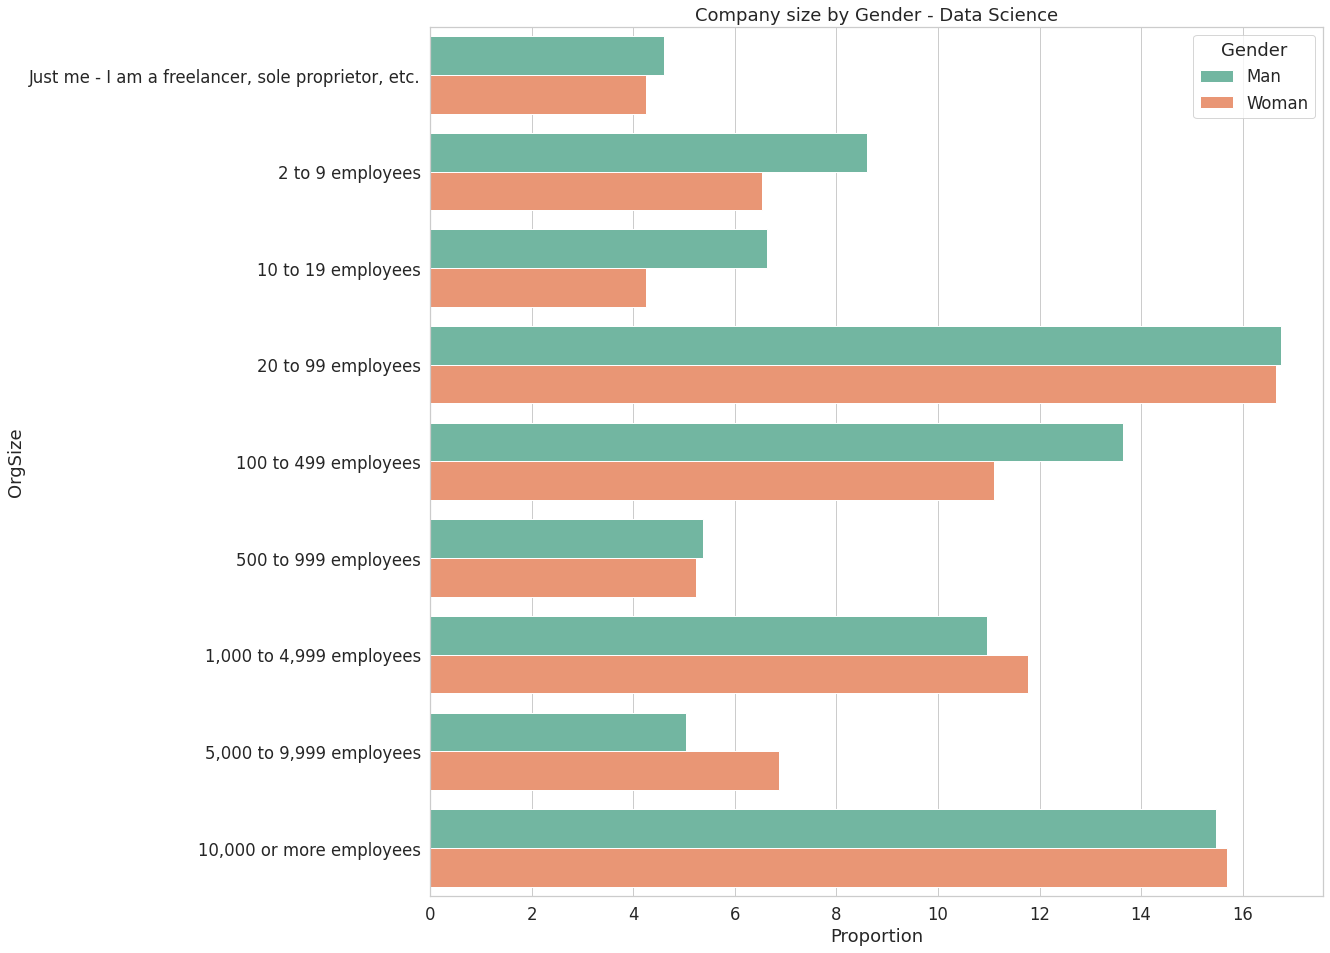

In [119]:
title_plot = 'Company size by Gender - Data Science'
order_list = ['Just me - I am a freelancer, sole proprietor, etc.', 
              '2 to 9 employees', 
              '10 to 19 employees', 
              '20 to 99 employees', 
              '100 to 499 employees', 
              '500 to 999 employees', 
              '1,000 to 4,999 employees', 
              '5,000 to 9,999 employees', 
              '10,000 or more employees']

analyse_gender_by_category(df_survey_data, 'OrgSize', 'Gender', order_list, title_plot)

There are bigger proportions of women in Data Science working for big organizations, while respondents belonging in smaller and medium companies are more likely to be men.